In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np


torch.set_printoptions(linewidth=120)  

## Preparing Data

In [2]:
train_data = torchvision.datasets.FashionMNIST(
    root = '../data',
    train = True,
    download = True,
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
)

train_loader = torch.utils.data.DataLoader(
    dataset = train_data,
    batch_size = 64,
)

In [3]:
print(train_data.targets)
print(train_data.targets.bincount())

tensor([9, 0, 0,  ..., 3, 0, 5])
tensor([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000])


In [4]:
sample = next(iter(train_data))

In [5]:
len(sample)  #

2

In [6]:
image, label = sample
print(image.shape)  # torch.Size([1, 28, 28])
 # 9

torch.Size([1, 28, 28])


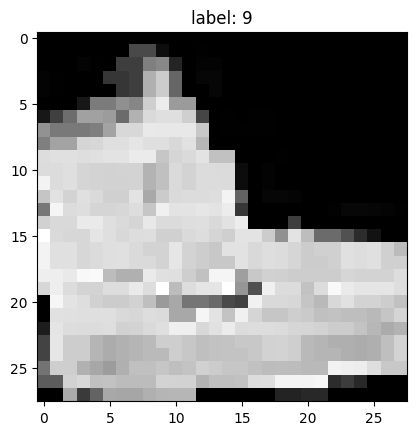

In [7]:
plt.imshow(image.squeeze(), cmap='gray')
plt.title(f"label: {label}")   # f-string is easiest
plt.show()


In [8]:
batch = next(iter(train_loader))
len(batch)  # 2

2

In [9]:
images, labels = batch
print(images.shape)  # torch.Size([10, 1, 28, 28

torch.Size([64, 1, 28, 28])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


Text(0.5, 1.0, 'labels: tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9, 1, 0, 6, 4, 3, 1, 4, 8, 4, 3, 0, 2, 4, 4, 5, 3, 6, 6, 0, 8, 5,\n        2, 1, 6, 6, 7, 9, 5, 9, 2, 7, 3, 0, 3, 3, 3, 7, 2, 2, 6, 6, 8, 3, 3, 5, 0, 5, 5])')

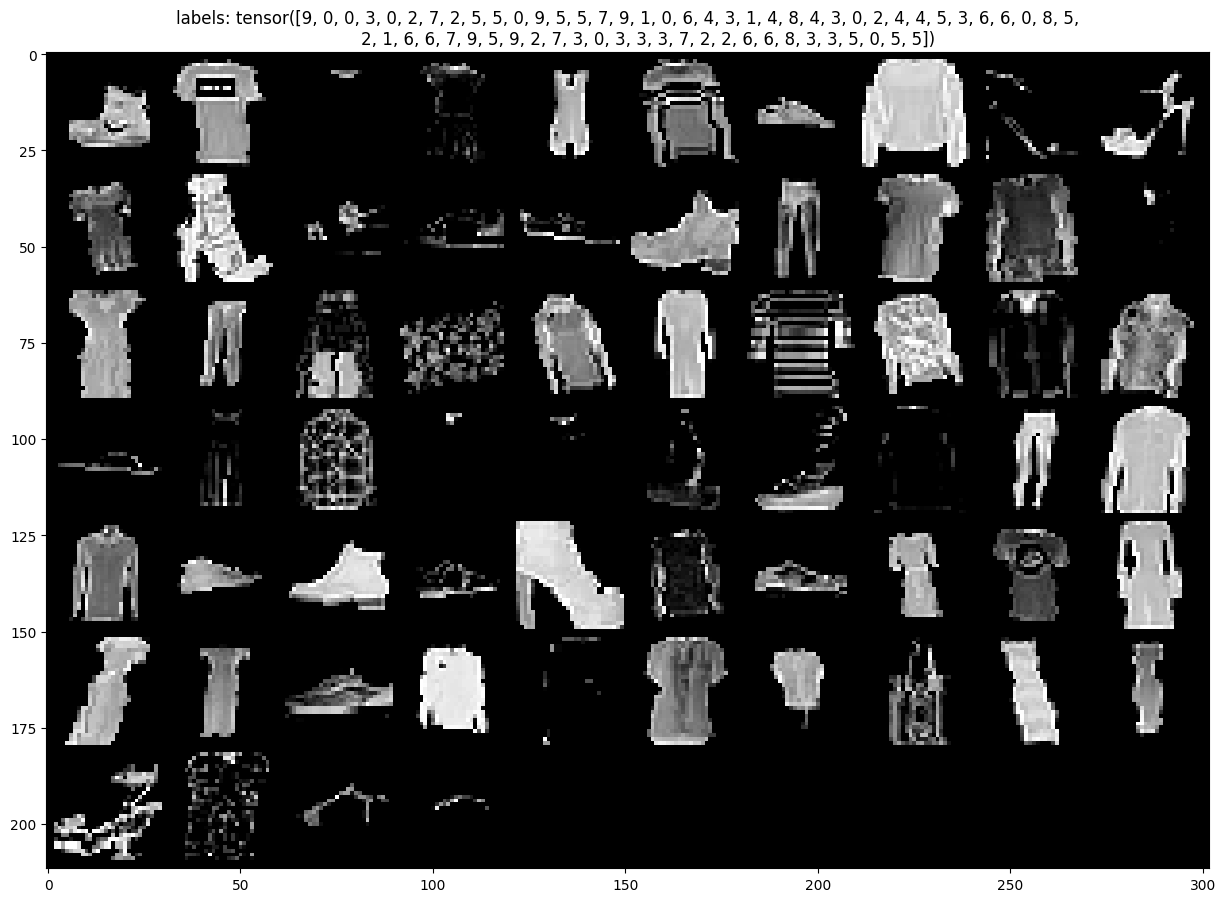

In [10]:
grid = torchvision.utils.make_grid(images, nrow=10)

plt.figure(figsize=(15,15))
plt.imshow(np.transpose(grid, (1,2,0)))
plt.title(f"labels: {labels}")

## Build the Model

In [11]:
import torch.nn as nn
import torch.nn.functional as F

In [12]:
# Model definition

import torch.nn as nn
import torch.nn.functional as F

class FashionClassifier(nn.Module):
    def __init__(self):
        super().__init__()

        # Convolutional layers with BatchNorm
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=5, padding=2)
        self.bn3 = nn.BatchNorm2d(128)

        self.pool = nn.MaxPool2d(2, 2)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 3 * 3, 256)   # increased hidden size
        self.bn4 = nn.BatchNorm1d(256)

        self.fc2 = nn.Linear(256, 128)
        self.bn5 = nn.BatchNorm1d(128)

        self.out = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))

        x = x.view(x.size(0), -1)  # flatten

        x = F.relu(self.bn4(self.fc1(x)))
        x = F.relu(self.bn5(self.fc2(x)))
        x = self.out(x)

        return x


In [13]:
model = FashionClassifier()
print(model)

FashionClassifier(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1152, out_features=256, bias=True)
  (bn4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (out): Linear(in_features=128, out_features=10, bias=True)
)


In [14]:
output = model(images)
print(output.shape)  # torch.Size([10, 10])

torch.Size([64, 10])


In [15]:
output[0]

tensor([ 0.1157,  0.1690, -0.0227,  0.3715, -0.0135, -0.1509, -0.1794, -0.0119,  0.1732,  0.1423],
       grad_fn=<SelectBackward0>)

In [16]:
for name, param in model.named_parameters():
    print(f"{name}: {param.shape}")


conv1.weight: torch.Size([32, 1, 5, 5])
conv1.bias: torch.Size([32])
bn1.weight: torch.Size([32])
bn1.bias: torch.Size([32])
conv2.weight: torch.Size([64, 32, 5, 5])
conv2.bias: torch.Size([64])
bn2.weight: torch.Size([64])
bn2.bias: torch.Size([64])
conv3.weight: torch.Size([128, 64, 5, 5])
conv3.bias: torch.Size([128])
bn3.weight: torch.Size([128])
bn3.bias: torch.Size([128])
fc1.weight: torch.Size([256, 1152])
fc1.bias: torch.Size([256])
bn4.weight: torch.Size([256])
bn4.bias: torch.Size([256])
fc2.weight: torch.Size([128, 256])
fc2.bias: torch.Size([128])
bn5.weight: torch.Size([128])
bn5.bias: torch.Size([128])
out.weight: torch.Size([10, 128])
out.bias: torch.Size([10])


In [17]:
test_data = torchvision.datasets.FashionMNIST(
    root = '../data',
    train = False,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
)

test_loader = torch.utils.data.DataLoader(
    dataset = test_data,
    batch_size = 64,
)

In [18]:
for batch_idx, (images, labels) in enumerate(test_loader):
    print(batch_idx)
    print(images.shape)
    print(labels.shape)
    break

0
torch.Size([64, 1, 28, 28])
torch.Size([64])


In [19]:
import torch.optim as optim
import time

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

FashionClassifier(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1152, out_features=256, bias=True)
  (bn4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (out): Linear(in_features=128, out_features=10, bias=True)
)

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
n_epochs = 20

In [22]:
best_acc = 0.0
patience = 3
trigger_times = 0

for epoch in range(n_epochs):
    # ---- training loop ----
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        batch_size = images.size(0)
        running_loss += loss.item() * batch_size
        _, predicted = torch.max(outputs, dim=1)
        total += batch_size
        correct += (predicted == labels).sum().item()

    scheduler.step()
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct / total * 100

    # ---- evaluation loop ----
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, dim=1)
            total += images.size(0)
            correct += (predicted == labels).sum().item()

    test_loss /= len(test_loader.dataset)
    test_acc = correct / total * 100

    print(f"Epoch {epoch+1}/{n_epochs}, "
          f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%, "
          f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

    # ---- Early stopping check ----
    if test_acc > best_acc:
        best_acc = test_acc
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping triggered 🚨")
            break


Epoch 1/20, Train Loss: 0.5088, Train Acc: 81.30%, Test Loss: 0.4004, Test Acc: 85.03%
Epoch 2/20, Train Loss: 0.3759, Train Acc: 85.95%, Test Loss: 0.3146, Test Acc: 88.37%
Epoch 3/20, Train Loss: 0.3412, Train Acc: 87.35%, Test Loss: 0.3302, Test Acc: 87.90%
Epoch 4/20, Train Loss: 0.3161, Train Acc: 88.15%, Test Loss: 0.2773, Test Acc: 89.72%
Epoch 5/20, Train Loss: 0.2989, Train Acc: 88.89%, Test Loss: 0.2811, Test Acc: 89.81%
Epoch 6/20, Train Loss: 0.2633, Train Acc: 90.10%, Test Loss: 0.2362, Test Acc: 91.24%
Epoch 7/20, Train Loss: 0.2545, Train Acc: 90.53%, Test Loss: 0.2293, Test Acc: 91.57%
Epoch 8/20, Train Loss: 0.2451, Train Acc: 90.85%, Test Loss: 0.2348, Test Acc: 91.25%
Epoch 9/20, Train Loss: 0.2383, Train Acc: 91.10%, Test Loss: 0.2240, Test Acc: 91.89%
Epoch 10/20, Train Loss: 0.2310, Train Acc: 91.34%, Test Loss: 0.2288, Test Acc: 91.63%
Epoch 11/20, Train Loss: 0.2122, Train Acc: 92.10%, Test Loss: 0.2116, Test Acc: 92.34%
Epoch 12/20, Train Loss: 0.2062, Train Ac

In [25]:
# ---- Save model weights ----
import os

os.makedirs("models", exist_ok=True)  # creates the folder if it doesn’t exist
torch.save(model.state_dict(), "../models/fashion_mnist.pth")
print("Model saved to models/fashion_mnist.pth")


Model saved to models/fashion_mnist.pth
